# Ensemble 策略模型

本notebook将整合之前实现的各种模型，构建一个ensemble策略。主要步骤包括：

1. 数据获取与预处理
2. 特征工程（技术指标构建）
3. 数据集划分（训练集、验证集、测试集）
4. 模型集成：
   - 线性回归（Day1）
   - 随机森林（Day2）
   - XGBoost（Day3）
   - MLP（Day4）
5. 模型权重优化
6. 策略回测与评估

## 0. 导入依赖包

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境
import sys

from dotenv import load_dotenv, find_dotenv
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")
# Load it explicitly
load_dotenv(dotenv_path)

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from data_processing import load_data_year, flatten_yf_columns, standardize_columns
from plotting import plot_results
from strategy.buy_and_hold import BuyAndHoldStrategy
from back_test import run_backtest
import backtrader as bt


# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False

## 1. 数据准备与特征工程

In [6]:
# 获取数据
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")

ticker = 'TSLA'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed

获取数据时间范围：2020-03-13 到 2025-03-12


In [7]:
data = flatten_yf_columns(data)
data = standardize_columns(data)

In [9]:
print(data.info())              # 看看总共有多少行、列，各字段数据类型
print(data.head(10))           # 查看前10行，确认最早日期
print(data.tail(10))           # 查看后10行，确认最晚日期
print(data.index.min())  # DataFrame中最早的日期
print(data.index.max())  # DataFrame中最晚的日期


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-03-13 to 2025-03-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1255 non-null   float64
 1   high    1255 non-null   float64
 2   low     1255 non-null   float64
 3   open    1255 non-null   float64
 4   volume  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB
None
             close    high     low    open     volume
Date                                                 
2020-03-13 36.4413 40.5047 33.4667 39.6667  339604500
2020-03-16 29.6713 32.9913 29.4780 31.3000  307342500
2020-03-17 28.6800 31.4567 26.4000 29.3340  359919000
2020-03-18 24.0813 26.9907 23.3673 25.9333  356793000
2020-03-19 28.5093 30.1333 23.8973 24.9800  452932500
2020-03-20 28.5020 31.8000 28.3860 29.2133  424282500
2020-03-23 28.9527 29.4667 27.3667 28.9067  246817500
2020-03-24 33.6667 34.2460 31.6000 31.8200  343428000
2020-03-25 35.9500 37

## 1.2. 加入技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。

In [10]:
# 复制数据
df = data.copy()

# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1

# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1

# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)

# 布林带
upper, middle, lower = talib.BBANDS(
    df['close'],
    timeperiod=20,
    nbdevup=2,
    nbdevdn=2,
    matype=0
)
df['BB_upper'] = upper
df['BB_middle'] = middle
df['BB_lower'] = lower

# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','BB_upper','BB_lower']
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))


              close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                  
2025-03-05 279.1000     -0.0402     0.1253 29.9017  397.3141  261.0209
2025-03-06 263.4500     -0.0656     0.0620 26.9042  393.4019  253.4611
2025-03-07 262.6700     -0.1035     0.0087 26.7602  388.5007  247.1973
2025-03-10 222.1500     -0.2196     0.0368 20.5942  389.9048  231.8462
2025-03-11 230.5800     -0.1524     0.0812 24.4922  388.9695  220.7665


## 3. 目标变量的定义

定义下期1日收益率作为目标变量。

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                 
2020-04-09 38.2000      0.2608     0.0272 54.1876   39.7858   25.4478
2020-04-13 43.3967      0.3561    -0.0236 61.5239   41.4042   24.5249
2020-04-14 47.3260      0.3751     0.0475 65.9624   44.2006   23.4940
2020-04-15 48.6553      0.3380     0.0749 67.3352   46.7505   22.9416
2020-04-16 49.6807      0.3578     0.1159 68.3941   48.6161   23.6360
2020-04-17 50.2593      0.3157     0.1495 69.0048   50.6157   23.8114
2020-04-20 49.7573      0.1466     0.1144 67.7812   52.1107   24.4419
2020-04-21 45.7813     -0.0326    -0.0262 58.8769   52.6247   25.6108
2020-04-22 48.8073      0.0031    -0.1078 62.8743   53.7665   25.9830
2020-04-23 47.0420     -0.0531    -0.1902 59.2555   54.5341   26.3247


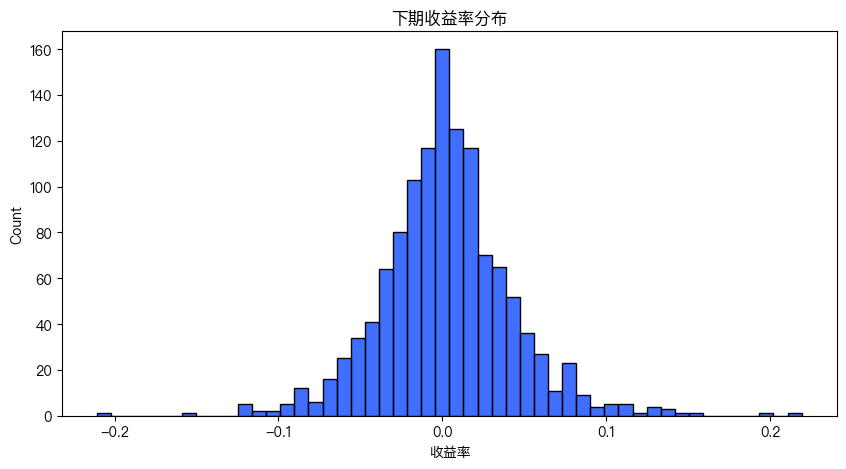

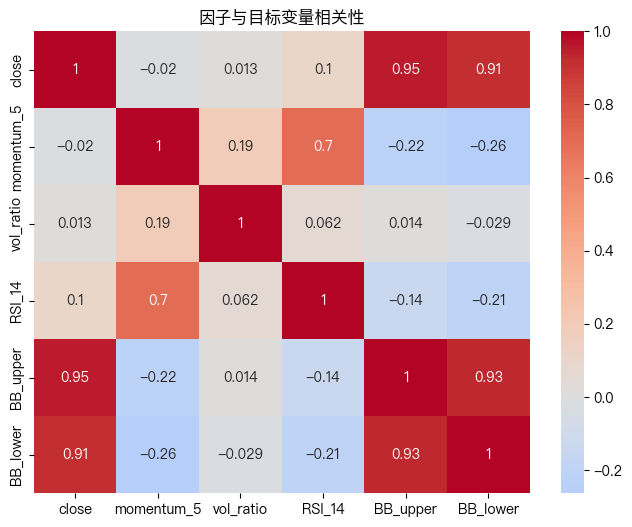

目标变量的均值=0.0022512106832757645
目标变量的方差=0.039952436916353626


In [11]:
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)

# 去掉NaN值
df.dropna(inplace=True)

print("添加目标变量后的数据预览：")
print(df[['close']+factors].head(10))

# 绘制目标变量分布
plt.figure(figsize=(10, 5))
sns.histplot(df['future_ret_1d'], bins=50)
plt.title('下期收益率分布')
plt.xlabel('收益率')
plt.show()

# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('因子与目标变量相关性')
plt.show()

print(f"目标变量的均值={np.mean(df['future_ret_1d'])}")
print(f"目标变量的方差={np.std(df['future_ret_1d'])}")

## 4. 划分训练集与测试集

按照时间顺序，使用前60%的数据作为训练集，中20%作为验证集，后20%作为测试集。

训练集范围: 2020-04-09 00:00:00 → 2023-03-20 00:00:00
验证集范围: 2023-03-21 00:00:00 → 2024-03-13 00:00:00
测试集范围: 2024-03-14 00:00:00 → 2025-03-10 00:00:00

训练集样本数: 741
验证集样本数: 247
测试集样本数: 247


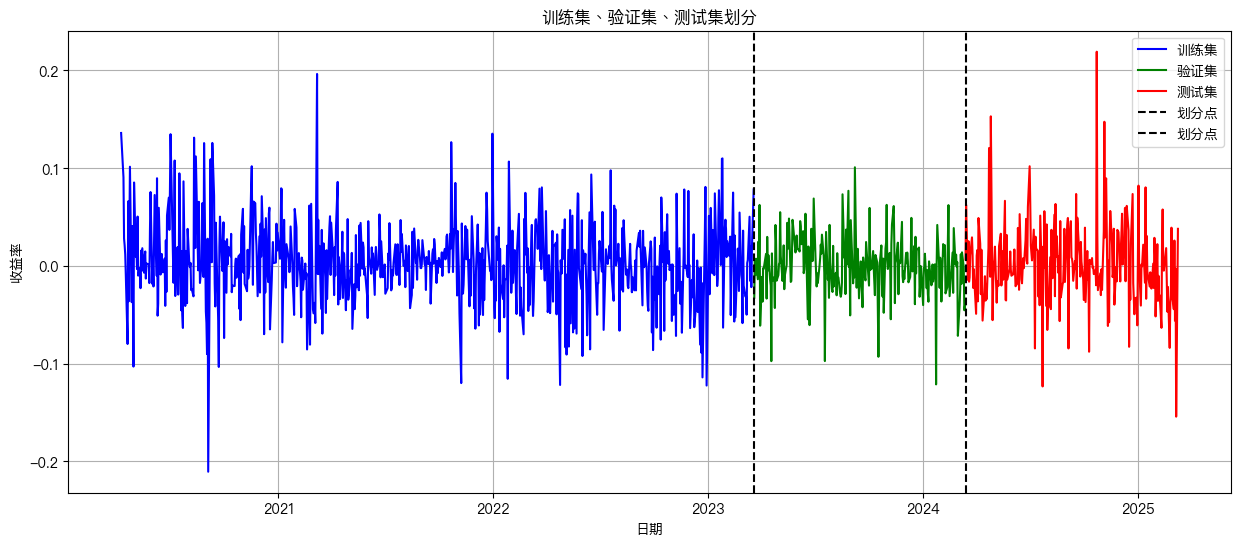

In [17]:
# 计算分割点
train_idx = int(len(df) * 0.6)
valid_idx = int(len(df) * 0.8)

split_date_1 = df.index[train_idx]
split_date_2 = df.index[valid_idx]

train_data = df.iloc[:train_idx].copy()
val_data = df.iloc[train_idx:valid_idx].copy()
test_data = df.iloc[valid_idx:].copy()

print("训练集范围:", train_data.index.min(), "→", train_data.index.max())
print("验证集范围:", val_data.index.min(), "→", val_data.index.max())
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())
print("\n训练集样本数:", len(train_data))
print("验证集样本数:", len(val_data))
print("测试集样本数:", len(test_data))

# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['future_ret_1d'], label='训练集', color='blue')
plt.plot(val_data.index, val_data['future_ret_1d'], label='验证集', color='green')
plt.plot(test_data.index, test_data['future_ret_1d'], label='测试集', color='red')
plt.axvline(split_date_1, color='black', linestyle='--', label='划分点')
plt.axvline(split_date_2, color='black', linestyle='--', label='划分点')
plt.title('训练集、验证集、测试集划分')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 741
验证集大小: 247
测试集大小: 247


# 3. Buy & Hold

In [81]:
# 若想看最优参数的详细回测日志，可再手动调用:
bh_result, bh_cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=BuyAndHoldStrategy,
    initial_cash=100000,
    print_log=True,  # 这次打开日志
    timeframe=bt.TimeFrame.Days,
    compression=1
)

初始资金: 100000.00
2024-03-14 00:00:00 [买入] 执行买入并持有策略: 价格=162.50, 数量=584
2024-03-15 00:00:00 [成交] 买单执行: 价格=163.21, 数量=584
2025-03-10 00:00:00 [回测结束] Buy & Hold 策略最终市值: 134325.64
2025-03-10 00:00:00 [回测结束] 总收益率: 34.33%
回测结束资金: 134325.64
=== 回测分析报告 ===
夏普比率: 0.7685
最大回撤比例: 52.84%
最大回撤金额(自定义): 150502.64
累计收益率: 29.51%
年化收益率: 35.13%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


In [82]:
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

In [83]:
plot_results(bh_cerebro)

## 4. 模型训练与超参数优化

In [84]:
features = factors
X_train = train_data[features].values
y_train = train_data['future_ret_1d'].values
X_val = val_data[features].values
y_val = val_data['future_ret_1d'].values
X_test = test_data[features].values
y_test = test_data['future_ret_1d'].values

## 4.1 训练线性模型

In [86]:
import copy
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再线性回归）
######################################
pipeline_lr = Pipeline([
    # ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

######################################
# 2. 定义线性模型的超参数搜索范围
#    这里只调节 fit_intercept 参数，你可以根据需要添加其他模型或参数
######################################
param_grid_lr = {
    'lr__fit_intercept': [True, False]
}

######################################
# 3. 遍历所有参数组合，寻找最佳线性模型（在验证集上评估）
######################################
best_score_lr = float('-inf')
best_params_lr = None
best_pipeline_lr = None

for params in ParameterGrid(param_grid_lr):
    pipeline_lr.set_params(**params)
    pipeline_lr.fit(X_train, y_train)
    
    # 在验证集上进行预测和评估
    valid_pred_lr = pipeline_lr.predict(X_valid)
    valid_r2_lr = r2_score(y_valid, valid_pred_lr)
    
    if valid_r2_lr > best_score_lr:
        best_score_lr = valid_r2_lr
        best_params_lr = params
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_lr = copy.deepcopy(pipeline_lr)
        print("更新：", best_score_lr, best_params_lr)

print("最佳参数：", best_params_lr)

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_lr = best_pipeline_lr.predict(X_train)
y_pred_test_lr  = best_pipeline_lr.predict(X_test)

train_mse_lr = mean_squared_error(y_train, y_pred_train_lr)
test_mse_lr  = mean_squared_error(y_test, y_pred_test_lr)
train_r2_lr  = r2_score(y_train, y_pred_train_lr)
test_r2_lr   = r2_score(y_test, y_pred_test_lr)

print("==== 线性模型 - 训练集 ====")
print("MSE:", train_mse_lr)
print("R2: ", train_r2_lr)

print("==== 线性模型 - 测试集 ====")
print("MSE:", test_mse_lr)
print("R2: ", test_r2_lr)

# 查看训练后的回归系数和截距
print("Coefficients:", best_pipeline_lr.named_steps['lr'].coef_)
print("Intercept:", best_pipeline_lr.named_steps['lr'].intercept_)


更新： 0.012250624042911218 {'lr__fit_intercept': True}
更新： 0.014918070223446267 {'lr__fit_intercept': False}
最佳参数： {'lr__fit_intercept': False}
==== 线性模型 - 训练集 ====
MSE: 0.001710414465843531
R2:  0.028470258040875107
==== 线性模型 - 测试集 ====
MSE: 0.0017636884120351428
R2:  0.011825729035671362
Coefficients: [-3.52703683e-02  3.14541394e-02  3.14772725e-04 -3.40794283e-05
 -2.65932454e-05]
Intercept: 0.0


## 4.2 训练随机森林

In [87]:
import copy
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 变量也定义了各特征名称

######################################
# 1. 建立 Pipeline（可选标准化，对 RF 来说不一定必要，但便于与其他模型比较）
######################################
pipeline_rf = Pipeline([
    # ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

######################################
# 2. 定义 RF 的超参数搜索范围
######################################
param_grid_rf = {
    'rf__n_estimators': [1000],
    'rf__max_depth': [3, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 8],
    'rf__max_features': [0.1, 0.3, 'sqrt']
}

######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 RF 模型
######################################
best_score_rf = float('-inf')
best_params_rf = None
best_pipeline_rf = None

for params in ParameterGrid(param_grid_rf):
    # 设置参数并训练模型
    pipeline_rf.set_params(**params)
    pipeline_rf.fit(X_train, y_train)
    
    # 在验证集上进行预测并计算 R2 得分
    valid_pred_rf = pipeline_rf.predict(X_valid)
    valid_r2_rf = r2_score(y_valid, valid_pred_rf)
    
    if valid_r2_rf > best_score_rf:
        best_score_rf = valid_r2_rf
        best_params_rf = params
        best_pipeline_rf = copy.deepcopy(pipeline_rf)
        print("更新：", best_score_rf, best_params_rf)

print("最佳参数：", best_params_rf)

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_rf = best_pipeline_rf.predict(X_train)
y_pred_test_rf  = best_pipeline_rf.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf  = mean_squared_error(y_test, y_pred_test_rf)
train_r2_rf  = r2_score(y_train, y_pred_train_rf)
test_r2_rf   = r2_score(y_test, y_pred_test_rf)

print("==== 训练集 ====")
print("MSE:", train_mse_rf)
print("R2 :", train_r2_rf)

print("==== 测试集 ====")
print("MSE:", test_mse_rf)
print("R2 :", test_r2_rf)

######################################
# 5. 查看特征重要性
######################################
feature_importances = best_pipeline_rf.named_steps['rf'].feature_importances_
for f, imp in zip(features, feature_importances):
    print(f"Feature: {f}, Importance: {imp:.4f}")

# 按重要性排序输出
sorted_idx = np.argsort(feature_importances)[::-1]
print("\nSorted Feature Importances:")
for idx in sorted_idx:
    print(f"{features[idx]} -> {feature_importances[idx]:.4f}")


更新： 0.005758677598567519 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
更新： 0.00688927155497665 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000}
更新： 0.007381167840402658 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
更新： 0.010235838544732201 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
更新： 0.01048365729798073 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000}
更新： 0.010489722258567702 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
更新： 0.012190380685350055 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_

# 3.3 训练XGBoost

In [88]:
import copy
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 列表也定义了各特征名称

######################################
# 1. 建立 Pipeline（XGBoost 通常不需要标准化）
######################################
pipeline_xgb = Pipeline([
    # 如果需要标准化，可取消注释下面这一行：
    # ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, verbosity=0))
])

######################################
# 2. 定义 XGBoost 的超参数搜索范围
######################################
param_grid_xgb = {
    'xgb__n_estimators': [100, 500, 1000],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 20],
    'xgb__subsample': [1.0, 0.8]
}

######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 XGBoost 模型
######################################
best_score_xgb = float('-inf')
best_params_xgb = None
best_pipeline_xgb = None

for params in ParameterGrid(param_grid_xgb):
    pipeline_xgb.set_params(**params)
    pipeline_xgb.fit(X_train, y_train)
    
    # 在验证集上进行预测并计算 R² 得分
    valid_pred_xgb = pipeline_xgb.predict(X_valid)
    valid_r2_xgb = r2_score(y_valid, valid_pred_xgb)
    
    if valid_r2_xgb > best_score_xgb:
        best_score_xgb = valid_r2_xgb
        best_params_xgb = params
        best_pipeline_xgb = copy.deepcopy(pipeline_xgb)
        print("更新：", best_score_xgb, best_params_xgb)

print("最佳参数：", best_params_xgb)

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_xgb = best_pipeline_xgb.predict(X_train)
y_pred_test_xgb  = best_pipeline_xgb.predict(X_test)

train_mse_xgb = mean_squared_error(y_train, y_pred_train_xgb)
test_mse_xgb  = mean_squared_error(y_test, y_pred_test_xgb)
train_r2_xgb  = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb   = r2_score(y_test, y_pred_test_xgb)

print("==== XGBoost - 训练集 ====")
print("MSE:", train_mse_xgb)
print("R2: ", train_r2_xgb)

print("==== XGBoost - 测试集 ====")
print("MSE:", test_mse_xgb)
print("R2: ", test_r2_xgb)

######################################
# 5. 查看特征重要性
######################################
feature_importances_xgb = best_pipeline_xgb.named_steps['xgb'].feature_importances_
for f, imp in zip(features, feature_importances_xgb):
    print(f"Feature: {f}, Importance: {imp:.4f}")

# 按重要性排序输出
sorted_idx_xgb = np.argsort(feature_importances_xgb)[::-1]
print("\nSorted Feature Importances (XGBoost):")
for idx in sorted_idx_xgb:
    print(f"{features[idx]} -> {feature_importances_xgb[idx]:.4f}")


更新： -0.006355114571211962 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
更新： 0.0019758360274022557 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
更新： 0.015032358373792243 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
最佳参数： {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
==== XGBoost - 训练集 ====
MSE: 0.0012524628643054696
R2:  0.288590603230204
==== XGBoost - 测试集 ====
MSE: 0.0019806592888099534
R2:  -0.109740550197311
Feature: momentum_5, Importance: 0.1734
Feature: vol_ratio, Importance: 0.2049
Feature: RSI_14, Importance: 0.2185
Feature: BB_upper, Importance: 0.2038
Feature: BB_lower, Importance: 0.1994

Sorted Feature Importances (XGBoost):
RSI_14 -> 0.2185
vol_ratio -> 0.2049
BB_upper -> 0.2038
BB_lower -> 0.1994
momentum_5 -> 0.1734


# 3.4 训练MLP

In [89]:
import copy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再 MLP 回归）
######################################
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(random_state=42, max_iter=1000))
])

######################################
# 2. 定义 MLP 的超参数搜索范围
######################################
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256)],
    'mlp__alpha': [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [1e-3, 1e-2],
    'mlp__solver': ['adam', 'sgd']
}

######################################
# 3. 遍历所有参数组合，寻找最优 MLP 模型（在验证集上评估）
######################################
best_score = float('-inf')
best_params = None
best_pipeline_mlp = None

for params in ParameterGrid(param_grid_mlp):
    # 设置 Pipeline 的参数
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    
    # 在验证集上进行预测和评估
    valid_pred = pipeline.predict(X_valid)
    valid_r2 = r2_score(y_valid, valid_pred)
    
    if valid_r2 > best_score:
        best_score = valid_r2
        best_params = params
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_mlp = copy.deepcopy(pipeline)
        print('updated', best_score, best_params)

print("Best Params:", best_params)

######################################
# 4. 使用最优模型在训练集和测试集上评估
######################################
y_pred_train_mlp = best_pipeline_mlp.predict(X_train)
y_pred_test_mlp  = best_pipeline_mlp.predict(X_test)

train_mse_mlp = mean_squared_error(y_train, y_pred_train_mlp)
test_mse_mlp  = mean_squared_error(y_test, y_pred_test_mlp)
train_r2_mlp  = r2_score(y_train, y_pred_train_mlp)
test_r2_mlp   = r2_score(y_test, y_pred_test_mlp)

print("==== MLP - 训练集 ====")
print("MSE:", train_mse_mlp)
print("R2: ", train_r2_mlp)

print("==== MLP - 测试集 ====")
print("MSE:", test_mse_mlp)
print("R2: ", test_r2_mlp)

updated -0.4151653557031676 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
updated -0.1506631889886274 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.05583089717663259 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 128), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated 0.009406988576607156 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated 0.012027576448328303 {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best Params: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
==== MLP - 训练集 ====
MSE: 0.0016249659482098556
R2:  0.07700573172005343
==== MLP - 测试集 ====
MSE: 0.001765236087664075
R2:  0.010958584235108426

## 4. 模型集成与权重优化

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

def optimize_weights_stacking(models, X_val, y_val):
    """
    使用Stacking思想，通过线性回归学习非负组合权重，再归一化使权重和为1，
    目标是最大化 r2_score。
    """
    # 获取各模型在验证集上的预测，构成新的特征矩阵（形状：[样本数, 模型数]）
    predictions = np.column_stack([model.predict(X_val) for model in models])
    
    # 采用线性回归拟合验证集目标值，要求系数非负
    # 注意：LinearRegression 的 positive 参数要求 sklearn>=1.1 版本
    lr = LinearRegression(positive=True)
    lr.fit(predictions, y_val)
    
    # 获取各模型的系数，并归一化使权重和为 1
    weights = lr.coef_
    normalized_weights = weights / np.sum(weights)
    
    # 计算组合预测的 r2_score
    combined_pred = predictions.dot(normalized_weights)
    score = r2_score(y_val, combined_pred)
    print("Stacking 优化得到的 r2_score：", score)
    
    return normalized_weights

# 使用示例
models = [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp]
optimal_weights = optimize_weights_stacking(models, X_val, y_val)

print("Stacking 优化后的最优模型权重：")
model_names = ['线性回归', '随机森林', 'XGBoost', 'MLP']
for name, weight in zip(model_names, optimal_weights):
    print(f"{name}: {weight:.4f}")

Stacking 优化得到的 r2_score： 0.021065675984971888
Stacking 优化后的最优模型权重：
线性回归: 0.1833
随机森林: 0.5811
XGBoost: 0.1398
MLP: 0.0958


## 5. Emsemble策略实现与回测

In [91]:
import backtrader as bt

# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):
    """
    简单示例，把data的volume包装成一个单独的子图指标。
    """
    lines = ('vol',)
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图

    def __init__(self):
        self.lines.vol = self.data.volume

class MLEnsembleStrategy(bt.Strategy):
    params = (
        ('target_percent', 0.98),   # 目标仓位百分比
    )

    def __init__(self,models,weights):
        self.models = models
        self.weights = weights
        
        
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False

        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)
        self.vol_5.plotinfo.subplot = True
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)
        self.vol_10.plotinfo.subplot = True

        # 添加其它因子指标

        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)
        
        # RSI指标，14日周期
        self.rsi_14 = bt.indicators.RSI(self.data.close, period=14)
        
        # 布林带指标，默认20日均线和2倍标准差，返回上轨、均线和下轨
        self.bb = bt.indicators.BollingerBands(self.data.close)

        self.last_trade_type = None  # 记录上一次交易类型（buy/sell）
        
        self.value_history_dates = []
        self.value_history_values = []

    def next(self):
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0
        rsi = self.rsi_14[0]
        bb_upper = self.bb.top[0]  # 布林带上轨
        bb_lower = self.bb.bot[0]  # 布林带下轨

        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio, rsi, bb_upper, bb_lower]]

         # 获取各模型的预测值，假设每个模型输出一个标量预测
        predictions = np.array([model.predict(X)[0] for model in self.models])
        # print("Predictions:", predictions)
        
        # 加权平均得到集成预测
        pred_ret = np.sum(predictions * self.weights)
        # print("Ensemble Prediction:", pred_ret)

        # 获取当前持仓状态
        current_position = self.getposition().size

        if pred_ret > 0 and current_position == 0:
            # 只有当当前没有仓位时，才执行买入
            self.order_target_percent(target=self.p.target_percent)
            self.last_trade_type = "BUY"
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")
        
        elif pred_ret <= 0 and current_position > 0:
            # 只有当当前有仓位时，才执行卖出
            self.order_target_percent(target=0.0)
            self.last_trade_type = "SELL"
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")

        # 只在交易执行时打印仓位信息
        if self.last_trade_type:
            print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")

        dt = self.data.datetime.date(0)
        self.value_history_dates.append(dt)
        self.value_history_values.append(self.broker.getvalue())

In [92]:
# 若想看多模型集成策略的详细回测日志，可调用如下回测函数:
ml_ensemble_result, ml_ensemble_cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=MLEnsembleStrategy,
    initial_cash=100000,
    strategy_params={
        'models': [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp],
        'weights': optimal_weights,   # 归一化后的各模型权重
        'target_percent': 0.98,       # 目标仓位百分比
    },
    print_log=True,  # 打开详细回测日志
)

# 如需进一步查看回测结果或可视化结果，可进一步操作 ml_ensemble_cerebro 或 ml_ensemble_result


初始资金: 100000.00
2024-04-11 => BUY signal, pred_ret=0.001634
Current position size: 0, Value: 100000.0
Current position size: 561, Value: 99151.55297853393
Current position size: 561, Value: 93782.77886964721
Current position size: 561, Value: 91331.21160890503
Current position size: 561, Value: 90399.94955446167
Current position size: 561, Value: 87303.22715761108
Current position size: 561, Value: 85687.55297853393
Current position size: 561, Value: 82882.55297853393
2024-04-23 => SELL signal, pred_ret=-0.000135
Current position size: 561, Value: 84357.97715761108
2024-04-24 => BUY signal, pred_ret=0.004501
Current position size: 0, Value: 94426.36402410886
Current position size: 570, Value: 100702.62031857297
Current position size: 570, Value: 99625.32066647336
Current position size: 570, Value: 114308.52623287961
Current position size: 570, Value: 108169.62379757687
Current position size: 570, Value: 106294.32762448117
Current position size: 570, Value: 106305.72136227414
Current po

In [93]:
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

In [94]:
plot_results(ml_ensemble_cerebro)

## 6. 比较策略和Buy&Hold

In [95]:
results = ml_ensemble_cerebro.run()  # cerebro.run() 返回一个列表，每个元素是一个策略实例
ml_strategy_instance = results[0]  # 如果你只有一个策略，就取第一个

results = bh_cerebro.run()
bh_strategy_instance = results[0]

2024-04-11 => BUY signal, pred_ret=0.001634
Current position size: 0, Value: 100000.0
Current position size: 561, Value: 99151.55297853393
Current position size: 561, Value: 93782.77886964721
Current position size: 561, Value: 91331.21160890503
Current position size: 561, Value: 90399.94955446167
Current position size: 561, Value: 87303.22715761108
Current position size: 561, Value: 85687.55297853393
Current position size: 561, Value: 82882.55297853393
2024-04-23 => SELL signal, pred_ret=-0.000135
Current position size: 561, Value: 84357.97715761108
2024-04-24 => BUY signal, pred_ret=0.004501
Current position size: 0, Value: 94426.36402410886
Current position size: 570, Value: 100702.62031857297
Current position size: 570, Value: 99625.32066647336
Current position size: 570, Value: 114308.52623287961
Current position size: 570, Value: 108169.62379757687
Current position size: 570, Value: 106294.32762448117
Current position size: 570, Value: 106305.72136227414
Current position size: 570

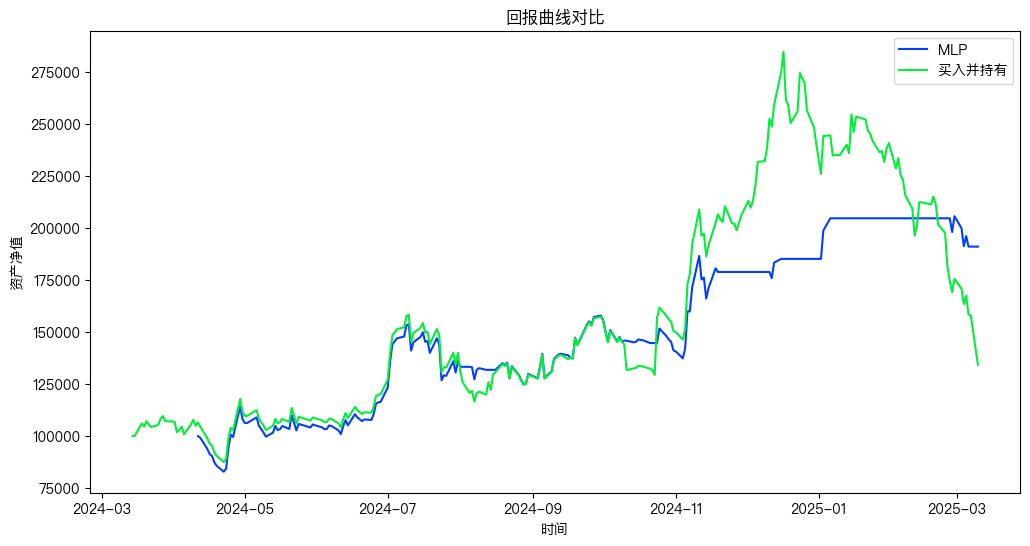

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(ml_strategy_instance.value_history_dates, ml_strategy_instance.value_history_values, label='MLP')
plt.plot(bh_strategy_instance.value_history_dates, bh_strategy_instance.value_history_values, label='买入并持有')
plt.xlabel('时间')
plt.ylabel('资产净值')
plt.title('回报曲线对比')
plt.legend()
plt.show()
